### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.RetFound import get_retfound
from src.FocalLoss import FocalLoss
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/opc/davidres/retina/mbrset/data'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'mBRSET/')
LABEL = 'final_icdr'
TEST_SIZE = 0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'file'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'dinov2_large'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 3

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df = df[df['file'] != '985.1.jpg'] # this is missing
df.head()

loading csv file in /home/chenweiw/retina/mbrset/data/labels.csv


patient  age  sex  dm_time  insulin  insulin_time  oraltreatment_dm  \
0        1   58    1     15.0      1.0           NaN               1.0   
1        1   58    1     15.0      1.0           NaN               1.0   
2        1   58    1     15.0      1.0           NaN               1.0   
3        1   58    1     15.0      1.0           NaN               1.0   
4       10   63    0      7.0      0.0           NaN               1.0   

   systemic_hypertension  insurance  educational_level  ...  nephropathy  \
0                    1.0        0.0                3.0  ...          1.0   
1                    1.0        0.0                3.0  ...          1.0   
2                    1.0        0.0                3.0  ...          1.0   
3                    1.0        0.0                3.0  ...          1.0   
4                    1.0        0.0                2.0  ...          0.0   

   neuropathy  diabetic_foot      file  laterality  final_artifacts  \
0         0.0            0.0   1.1.jpg       right              yes   
1         0.0            0.0   1.2.jpg       right              yes   
2         0.0            0.0   1.3.jpg        left              yes   
3         0.0            0.0   1.4.jpg        left              yes   
4         0.0            0.0  10.1.jpg       right              yes   

   final_quality  final_icdr final_edema normality  
0            yes         4.0          no  abnormal  
1            yes         4.0          no  abnormal  
2            yes         4.0          no  abnormal  
3            yes         4.0          no  abnormal  
4            yes         0.0          no  abnormal  

[5 rows x 25 columns]

In [4]:
# Convert into 3 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else ('Non-proliferative' if x in [1, 2, 3] else 'Proliferative'))

Train data shape: (3614, 25)
Test data shape: (1549, 25)


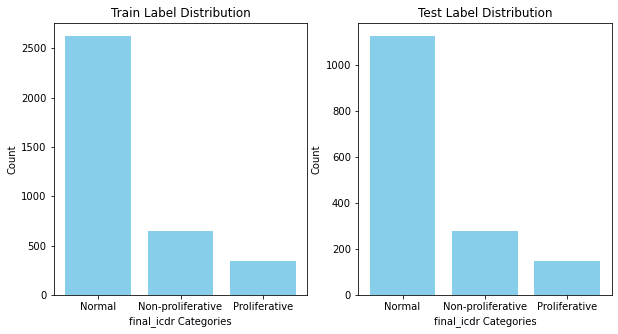

Getting validation set...
Train data shape: (1239, 25)
Test data shape: (310, 25)


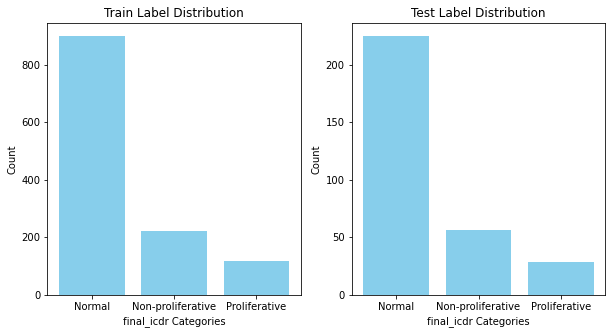

In [5]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [9]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

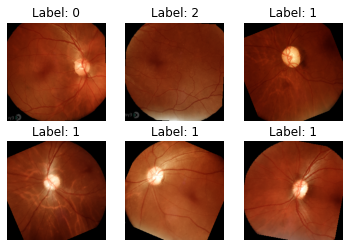

In [10]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels

for batch in train_dataloader:

    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()
    break

### Model

In [11]:
# Create a DataLoader to generate embeddings
#model = get_retfound(weights='/scratch/liyues_root/liyues/chenweiw/retina_datasets/retfound_weigths/RETFound_cfp_weights.pth', num_classes=3)
# Create a DataLoader to generate embeddings
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using cache found in /home/chenweiw/.cache/torch/hub/facebookresearch_dinov2_main


### Training:

In [12]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [13]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'convnextv2_3class_{LABEL}')

100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


Epoch 1, Train Loss: 0.9567628107239715, Val Loss: 0.9554210543632508, F1 Score: 0.5238069567449622


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


Epoch 2, Train Loss: 0.8845524034932651, Val Loss: 0.9124286413192749, F1 Score: 0.48067568253440934


100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


Epoch 3, Train Loss: 0.870700806906793, Val Loss: 0.8401897490024567, F1 Score: 0.5179041369777585


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


Epoch 4, Train Loss: 0.8008176986358863, Val Loss: 0.7841848880052567, F1 Score: 0.6499230806194971


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch 5, Train Loss: 0.7661738909978782, Val Loss: 0.9362250536680221, F1 Score: 0.3337017521312599


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Epoch 6, Train Loss: 0.7434003585207779, Val Loss: 0.752466981112957, F1 Score: 0.6468227077572104


100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


Epoch 7, Train Loss: 0.707076814520148, Val Loss: 0.9463767349720001, F1 Score: 0.46602267365714584


100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


Epoch 8, Train Loss: 0.7653445811134524, Val Loss: 0.7494598835706711, F1 Score: 0.644511636430273


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Epoch 9, Train Loss: 0.7145544638675926, Val Loss: 0.7489822044968605, F1 Score: 0.6510245475548181


100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


Epoch 10, Train Loss: 0.6705410837204056, Val Loss: 0.8434233993291855, F1 Score: 0.643967170727055


100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Epoch 11, Train Loss: 0.7031047141789335, Val Loss: 0.7592660307884216, F1 Score: 0.7419536325168367


100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Epoch 12, Train Loss: 0.7822570151987329, Val Loss: 0.8234086900949478, F1 Score: 0.7093729164473453


100%|██████████| 20/20 [00:08<00:00,  2.40it/s]


Epoch 13, Train Loss: 0.6799252320707372, Val Loss: 0.8261219233274459, F1 Score: 0.6779588832220411


100%|██████████| 20/20 [00:04<00:00,  4.49it/s]


Epoch 14, Train Loss: 0.6467407405112697, Val Loss: 0.7297540470957756, F1 Score: 0.6182850288685304


100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


Epoch 15, Train Loss: 0.6302276007105819, Val Loss: 0.7124268308281898, F1 Score: 0.6406036788384913


100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


Epoch 16, Train Loss: 0.6015636638729973, Val Loss: 0.744798943400383, F1 Score: 0.5968762693242318


100%|██████████| 20/20 [00:04<00:00,  4.75it/s]


Epoch 17, Train Loss: 0.6474934779437242, Val Loss: 0.6947506576776504, F1 Score: 0.6750384835290495


100%|██████████| 20/20 [00:04<00:00,  4.58it/s]


Epoch 18, Train Loss: 0.6040341478929055, Val Loss: 0.7633335217833519, F1 Score: 0.5598698689613398
Early stopping triggered.


### Test

100%|██████████| 78/78 [00:15<00:00,  4.91it/s]


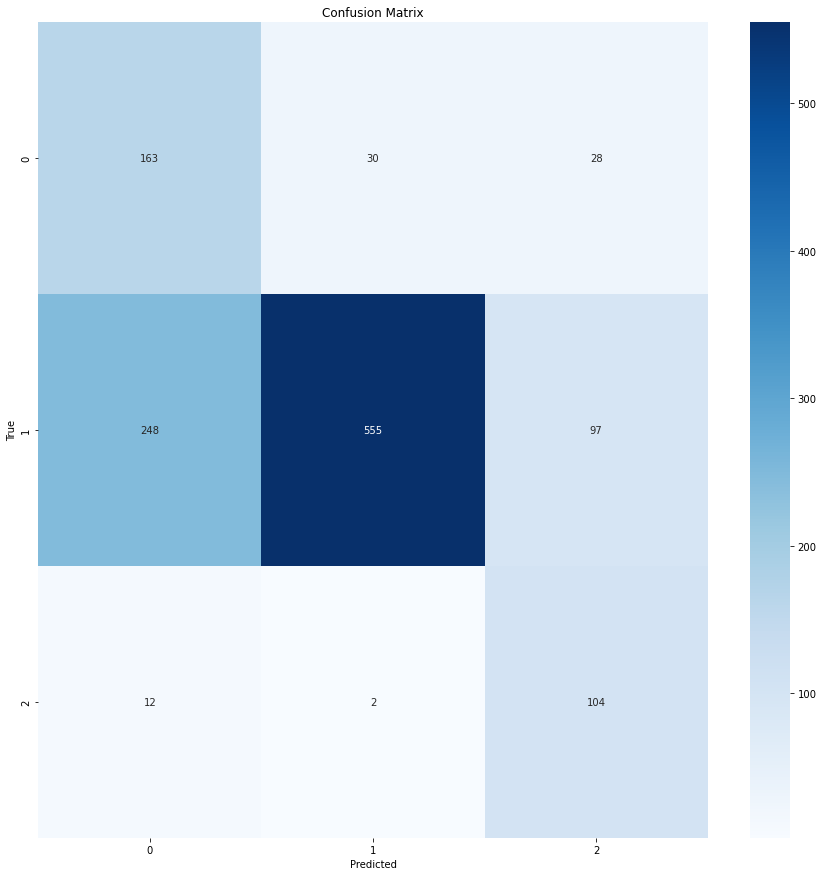

              precision    recall  f1-score   support

           0       0.39      0.74      0.51       221
           1       0.95      0.62      0.75       900
           2       0.45      0.88      0.60       118

    accuracy                           0.66      1239
   macro avg       0.59      0.75      0.62      1239
weighted avg       0.80      0.66      0.69      1239

##################################################  Saliency Maps  ##################################################

Class 0:


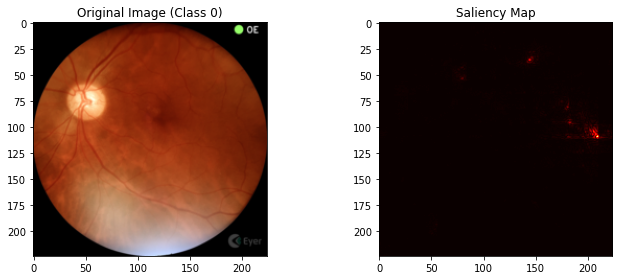

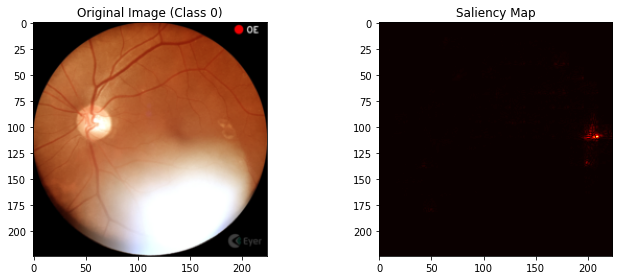

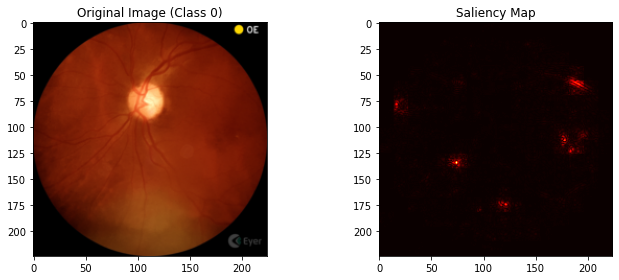

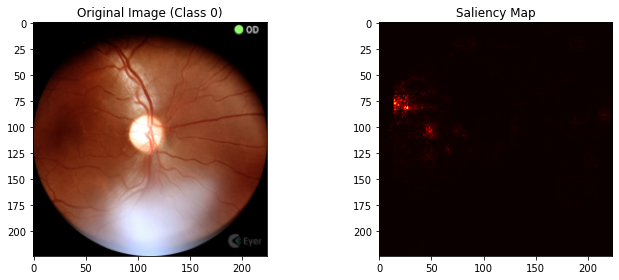

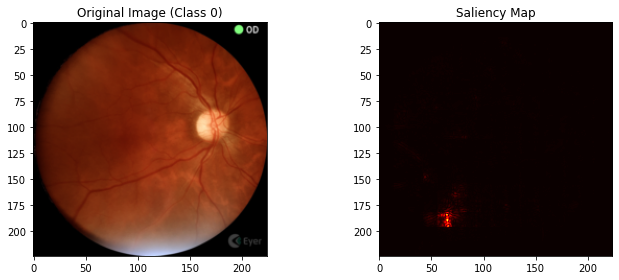

Class 1:


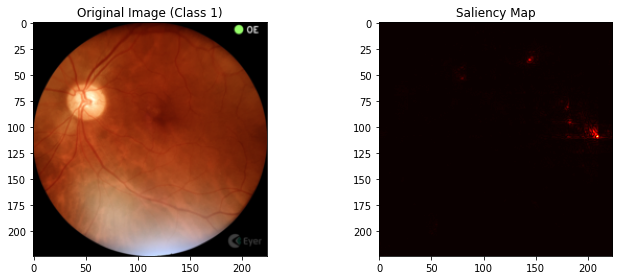

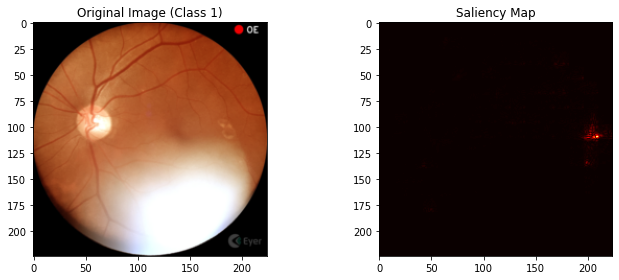

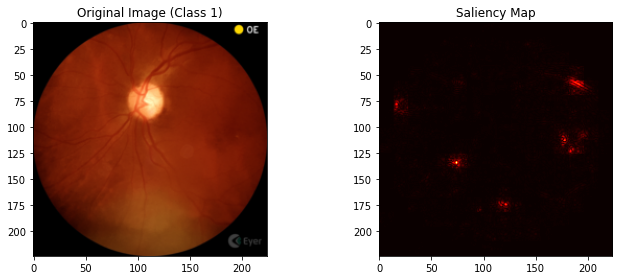

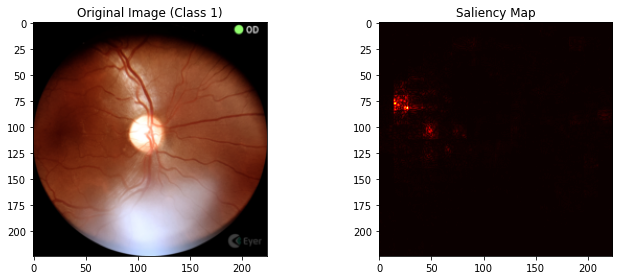

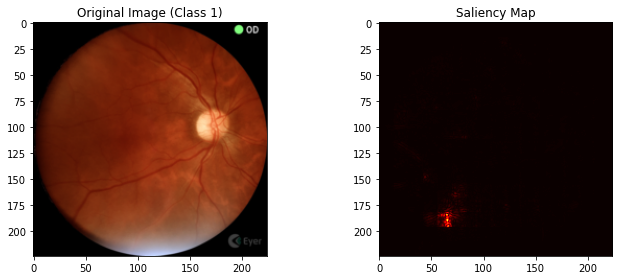

Class 2:


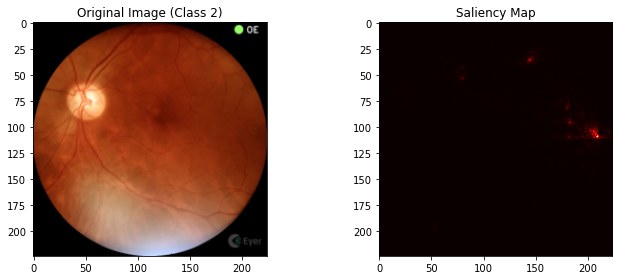

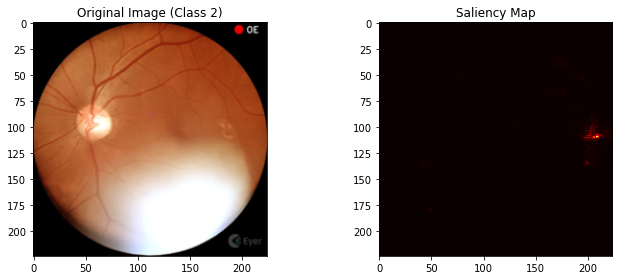

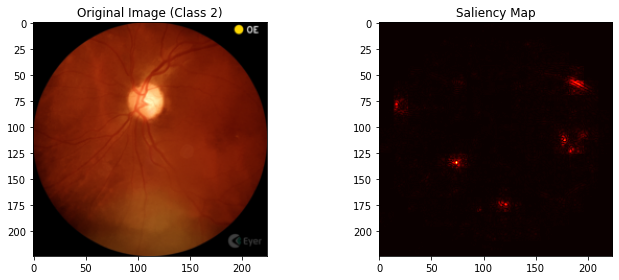

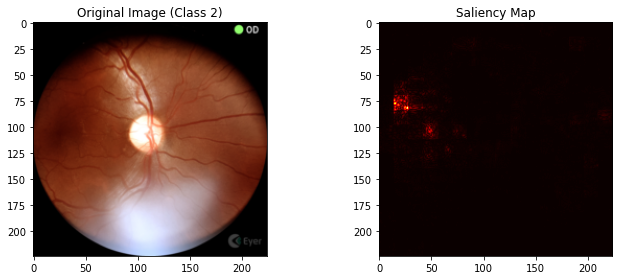

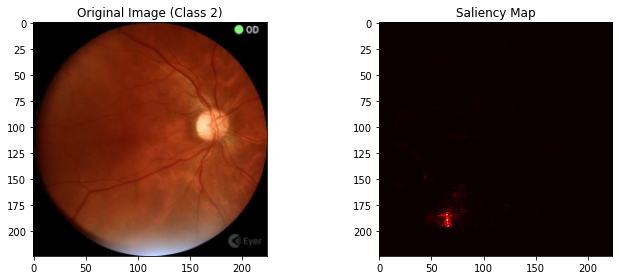

In [14]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [15]:
# Good quality images
adequate_df = df_test[df_test['final_quality'] == 'yes']

# Bad quality images
inadequate_df = df_test[df_test['final_quality'] == 'no']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 73/73 [00:15<00:00,  4.64it/s]


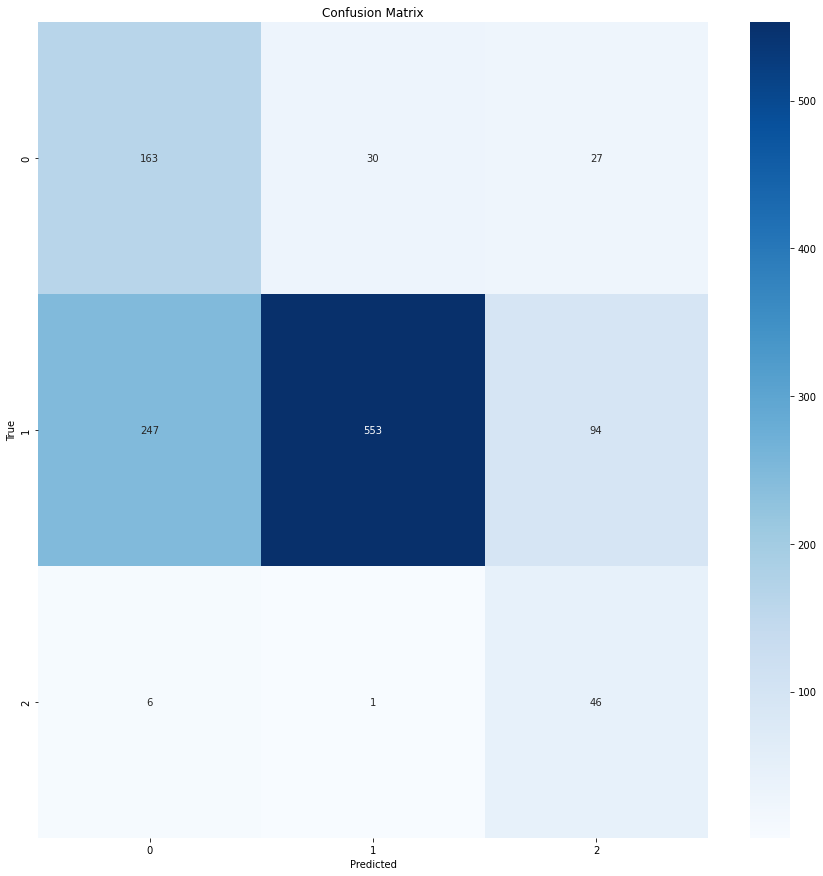

              precision    recall  f1-score   support

           0       0.39      0.74      0.51       220
           1       0.95      0.62      0.75       894
           2       0.28      0.87      0.42        53

    accuracy                           0.65      1167
   macro avg       0.54      0.74      0.56      1167
weighted avg       0.81      0.65      0.69      1167

##################################################  Saliency Maps  ##################################################

Class 0:


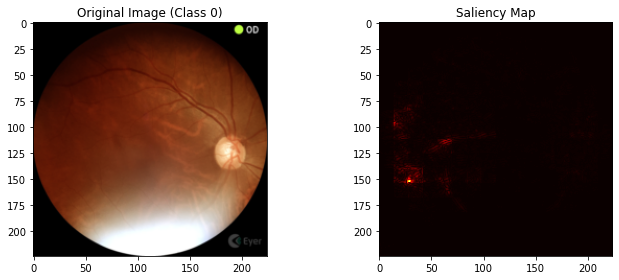

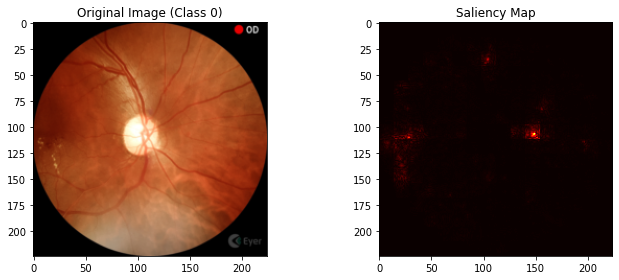

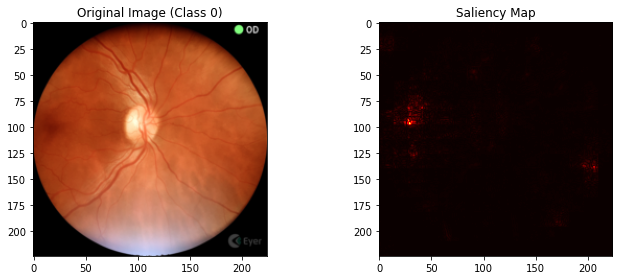

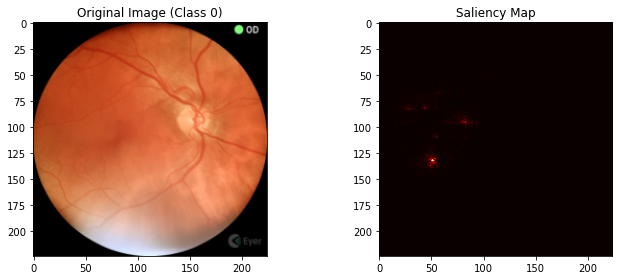

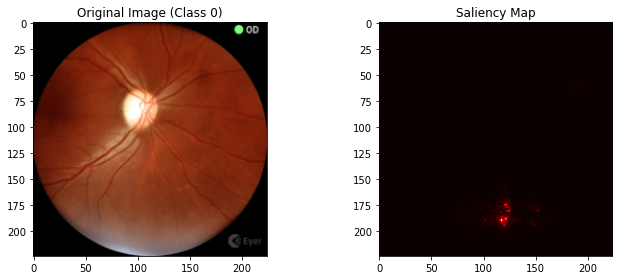

Class 1:


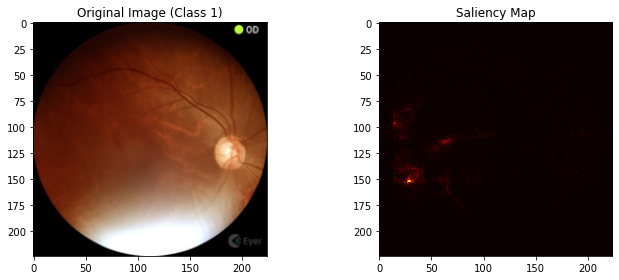

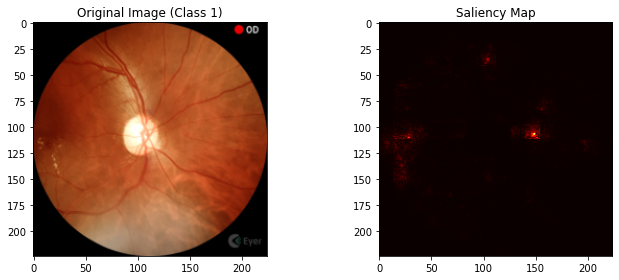

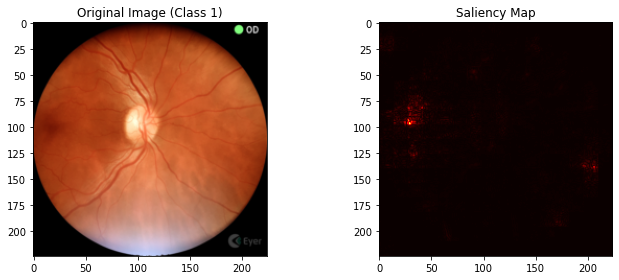

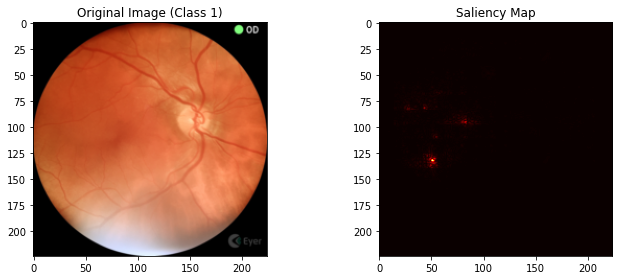

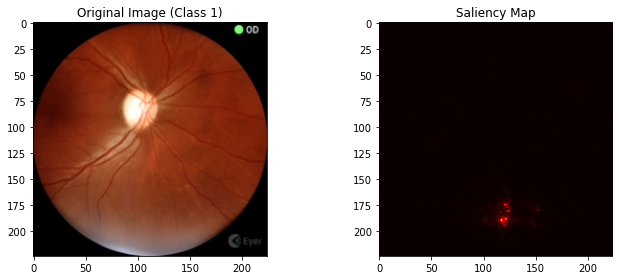

Class 2:


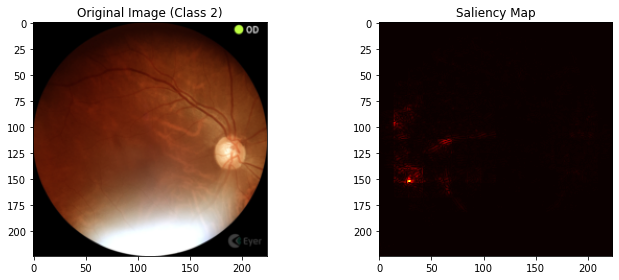

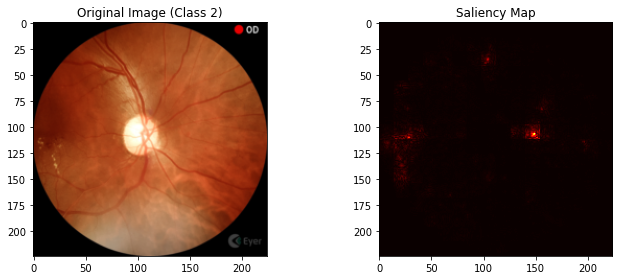

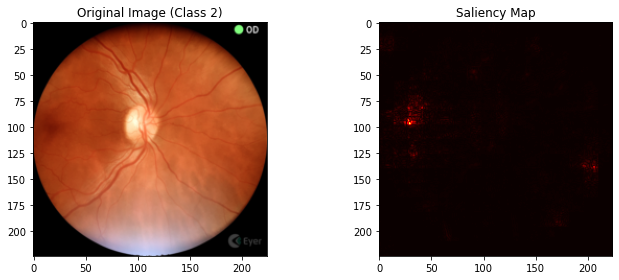

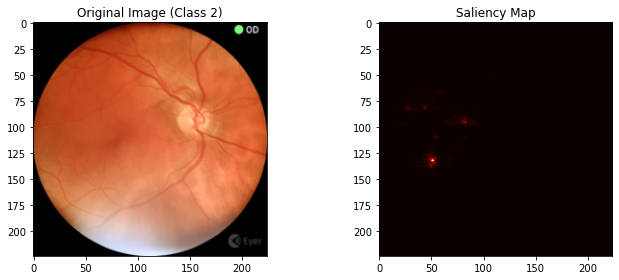

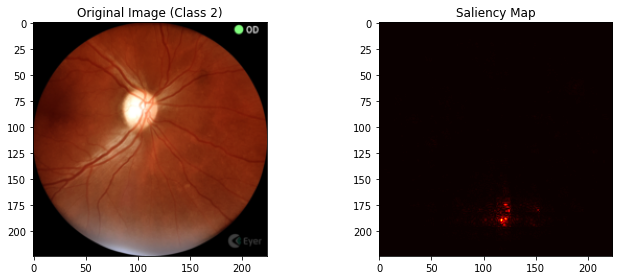

In [16]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


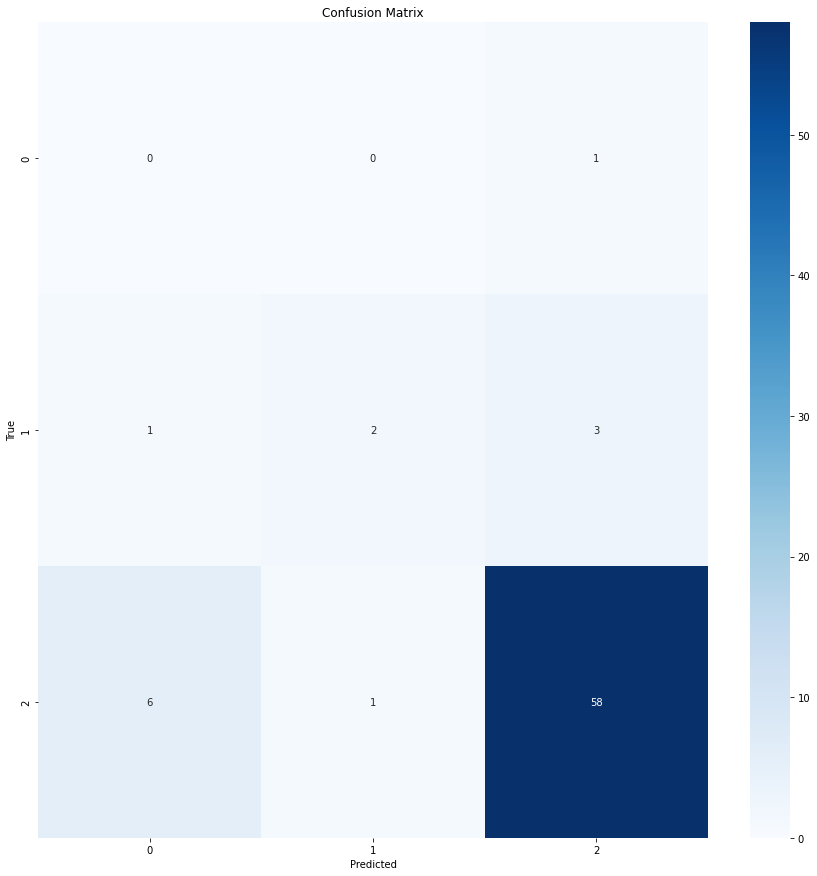

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      0.33      0.44         6
           2       0.94      0.89      0.91        65

    accuracy                           0.83        72
   macro avg       0.53      0.41      0.45        72
weighted avg       0.90      0.83      0.86        72

##################################################  Saliency Maps  ##################################################

Class 0:


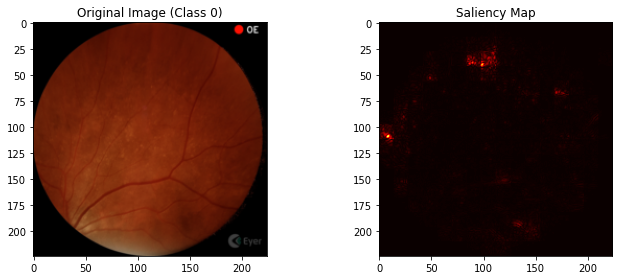

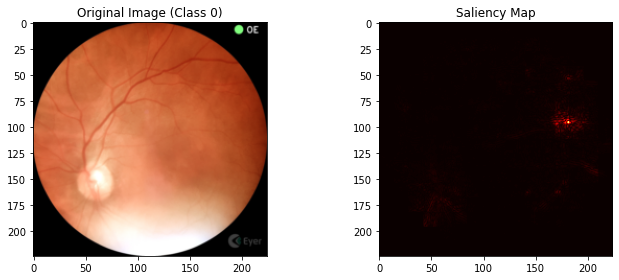

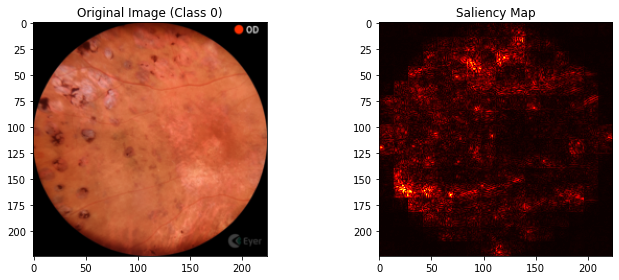

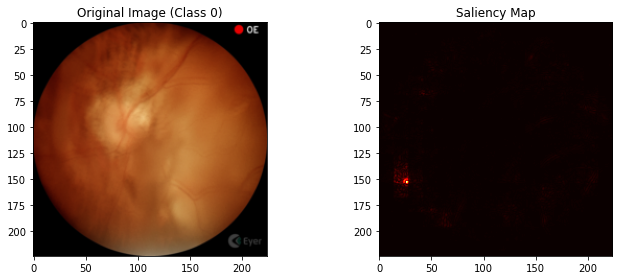

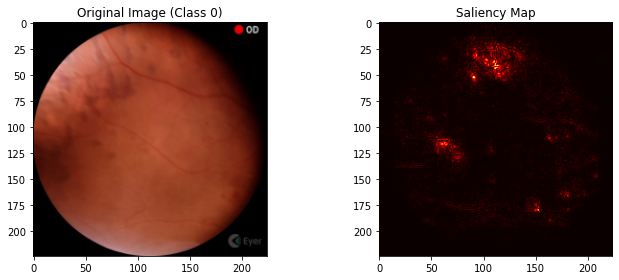

Class 1:


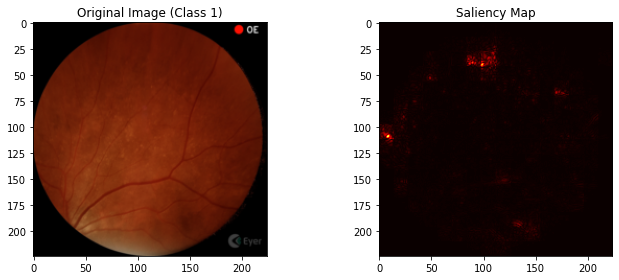

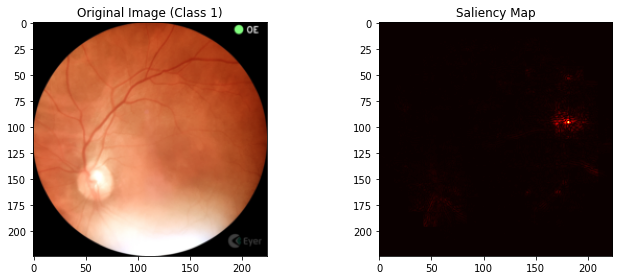

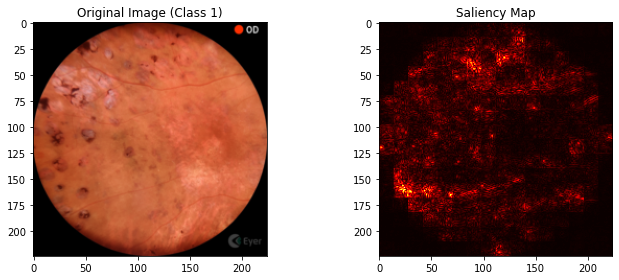

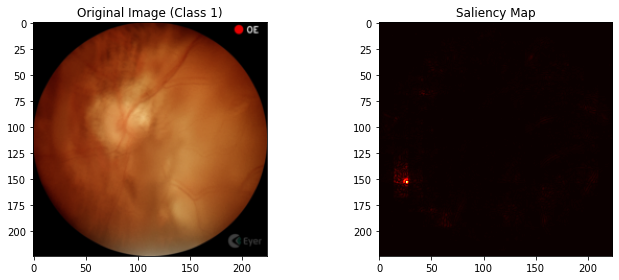

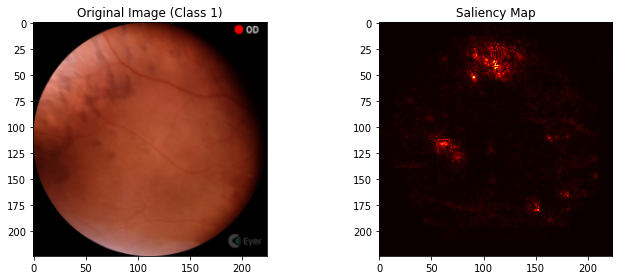

Class 2:


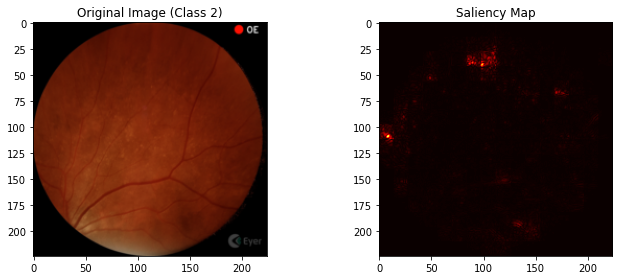

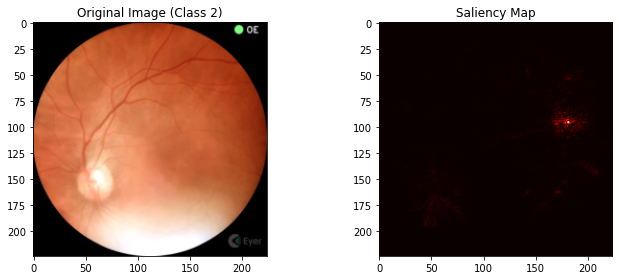

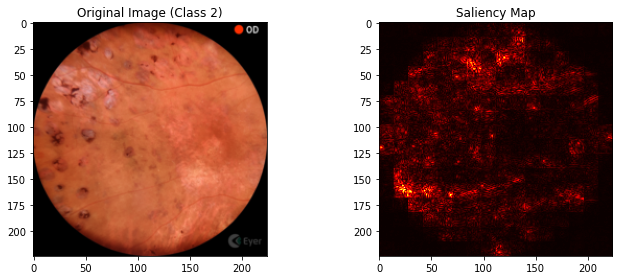

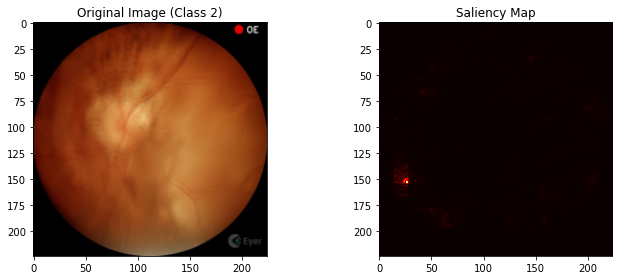

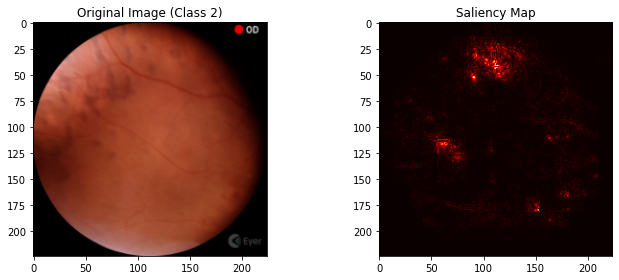

In [17]:
test(model, inadequate_dataloader, saliency=True, device=device)